In [2]:
import os,sys,glob,cv2,json
import cv2
import torch
import numpy as np
from src.unet_plus import UnetPlusPlus

In [81]:
model =torch.load("./best.pt")

In [82]:
def predict(path,model,device = "cuda",thresold = 0.5, verbose = True):
    '''
    demo predict
    path la file cv2 doc
    model 
    device :cpu|cuda
    verbose =True : return mask_predict,origin_img,origin_mask
    else return mask_predict
    
    mask_predict > thresold : la background
    mask_predict < thresold : la class 
    label_class = 0 : em de luc training :(
    '''
    
    def to_tensor(x, **kwargs):
        return x.transpose(2, 0, 1).astype('float32')

    def preprocess_input(
        x, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],
        input_space="RGB", input_range=[0,1], **kwargs
    ):

        if input_space == "BGR":
            x = x[..., ::-1].copy()

        if input_range is not None:
            if x.max() > 1 and input_range[1] == 1:
                x = x / 255.0

        if mean is not None:
            mean = np.array(mean)
            x = x - mean

        if std is not None:
            std = np.array(std)
            x = x / std

        return x
    
    img_ =cv2.imread(path)
    img_ = cv2.resize(img_,(256,256))
    img_ = cv2.cvtColor(img_,cv2.COLOR_BGR2RGB)
    
    img = preprocess_input(img_)
    img = to_tensor(img)
    img = img[np.newaxis,...]
    
    with torch.no_grad():
        img_tensor = torch.from_numpy(img).float().to(device)
        print(img_tensor.size())
        predict = model(img_tensor)
        predict = predict.squeeze().cpu().numpy() # single image
        predict = predict < thresold
        predict = predict.astype("int")
    if not verbose:return predict
    
    namex = path.split("/")[-1].split(".")[0] 
    name ="/".join([i for i in path.split("/")[:-2]]) + "/masks/" +namex + "_color_mask.png"
#     print(name)
    img_mask =cv2.imread(name)
    img_mask = cv2.resize(img_mask,(256,256))
    img_mask = cv2.cvtColor(img_mask,cv2.COLOR_BGR2RGB)
    
    
    return predict,img_,img_mask
    

In [83]:
path = "./validation/images/1121.jpg"
mask,origin_img,origin_mask = predict(path,model)

torch.Size([1, 3, 256, 256])


In [84]:
mask.shape,origin_img.shape,origin_mask.shape

((256, 256), (256, 256, 3), (256, 256, 3))

In [85]:
import matplotlib.pyplot as plt
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

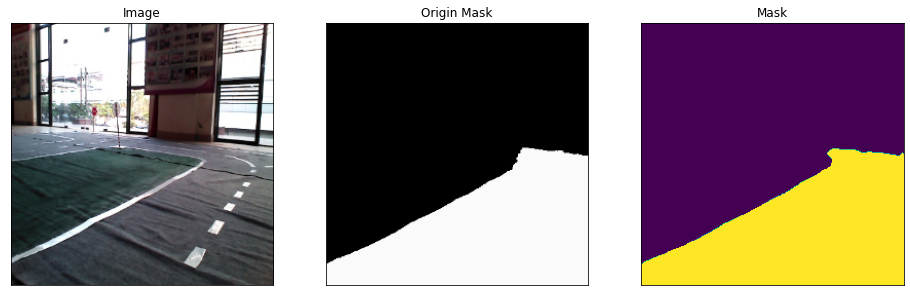

In [86]:

visualize(image = origin_img,origin_mask = origin_mask, mask = mask)

In [79]:
mask = mask < 0.5
mask = mask.astype("int")

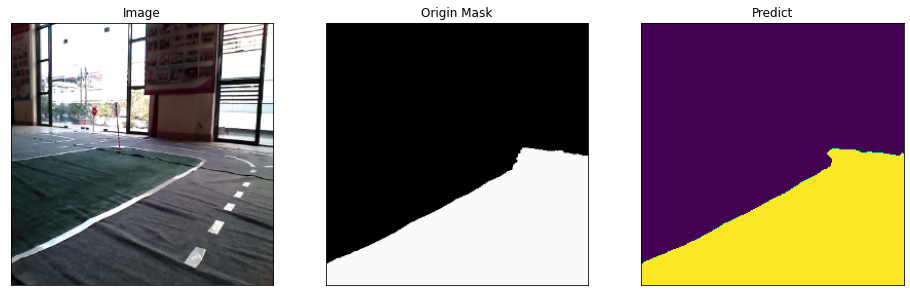

In [80]:

visualize(image = origin_img,origin_mask = origin_mask, predict = mask)